In [1]:
# Import all the necessary libraries

import copy
import math

import numpy as np  
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import mplcursors
import mpld3

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

print(torch.__version__)

%matplotlib inline

1.3.1


## Read the CSV and Perform Basic Data Cleaning

In [2]:
df = pd.read_csv("googleplaystore.csv")
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
df.head(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up


In [3]:
#df.info()#Check the data type of the column values whether they are object or float
#df.info()

In [4]:
# Get names of indexes for which column has  a non numeric value
indexNames = df[ df['Size'] == 'Varies with device' ].index
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)
df.head(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up


In [5]:
# Get rid of the non numeric values from the rows with numbers

df['Price'] = df['Price'].apply(lambda x: x.replace('$', '')
                                if isinstance(x, str) else x).astype(float)
df['Reviews'] = df['Reviews'].apply(lambda x: x.replace('M', '').replace(',', '').replace('+', '')
                                if isinstance(x, str) else x).astype(float) 
df['Size'] = df['Size'].apply(lambda x: x.replace('M', '').replace(',', '').replace('+', '').replace('k', '')
                                if isinstance(x, str) else x).astype(float) 
df['Installs'] = df['Installs'].apply(lambda x: x.replace('M', '').replace(',', '').replace('+', '')
                                if isinstance(x, str) else x).astype(float) 

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7723 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             7723 non-null   object 
 1   Category        7723 non-null   object 
 2   Rating          7723 non-null   float64
 3   Reviews         7723 non-null   float64
 4   Size            7723 non-null   float64
 5   Installs        7723 non-null   float64
 6   Type            7723 non-null   object 
 7   Price           7723 non-null   float64
 8   Content Rating  7723 non-null   object 
 9   Genres          7723 non-null   object 
 10  Last Updated    7723 non-null   object 
 11  Current Ver     7723 non-null   object 
 12  Android Ver     7723 non-null   object 
dtypes: float64(5), object(8)
memory usage: 844.7+ KB


In [6]:
#Save the clean data frame as a new csv file
#app_df.to_csv('df')

In [7]:
# Clean the CSV DF Column headers
app_df = df.rename(columns = {'Content Rating':'ContentRating','Last Updated':'LastUpdated', 'Current Ver':'CurrentVer','Android Ver':'AndroidVer'})
app_df['ContentRatingNum']=0.0
app_df.head(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,ContentRating,Genres,LastUpdated,CurrentVer,AndroidVer,ContentRatingNum
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19.0,10000.0,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,0.0
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,0.0


In [8]:
#print(app_df.Category.unique())
#print(app_df.ContentRating.unique())

ContentRating_dict = dict()
ContentRating_dict_2 = dict()


ContentRating_int = 1.0
for i in app_df.ContentRating.unique() :
    ContentRating_dict[i] = ContentRating_int
    ContentRating_dict_2[ContentRating_int] = i
    ContentRating_int = ContentRating_int + 2.0
    
for i in range(len(app_df)) :
    u = app_df['ContentRating'].values[i]
    v = ContentRating_dict.get(u, 0.0)
    app_df['ContentRatingNum'].values[i] = v    
    #print(v)

app_df_copy = app_df.copy(deep=True)    

print(ContentRating_dict)
print(ContentRating_dict_2)

app_df.head(3)

{'Everyone': 1.0, 'Teen': 3.0, 'Everyone 10+': 5.0, 'Mature 17+': 7.0, 'Adults only 18+': 9.0, 'Unrated': 11.0}
{1.0: 'Everyone', 3.0: 'Teen', 5.0: 'Everyone 10+', 7.0: 'Mature 17+', 9.0: 'Adults only 18+', 11.0: 'Unrated'}


,App,Category,Rating,Reviews,Size,Installs,Type,Price,ContentRating,Genres,LastUpdated,CurrentVer,AndroidVer,ContentRatingNum
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19.0,10000.0,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,1.0
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,1.0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8.7,5000000.0,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,1.0


In [9]:
#PyTorch

In [10]:
class SVM(nn.Module):
    """
    Linear Support Vector Machine
    -----------------------------
    This SVM is a subclass of the PyTorch nn module that
    implements the Linear  function. The  size  of  each 
    input sample is 5 and output sample  is 1.
    """
    def __init__(self):
        super().__init__()  # Call the init function of nn.Module
        self.fully_connected = nn.Linear(5, 1) #(2, 1)  # Implement the Linear function 
        # 5 = X_train.shape[1], i.e., number of features
        
    def forward(self, x):
        fwd = self.fully_connected(x)  # Forward pass
        return fwd

In [11]:
#dtype = torch.float
#device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

In [12]:
app_df_copy.head()

app_df_copy.fillna(0.1)

data_g = app_df_copy[['Reviews', 'Price', 'Size', 'Installs', 'Rating']]
data_g = data_g.apply(
    lambda x: (x - x.mean()) / x.std()
)

data_g['ContentRatingNum'] = app_df_copy.ContentRatingNum

data_g

,Reviews,Price,Size,Installs,Rating,ContentRatingNum
0,-0.158128,-0.064807,-0.195709,-0.167753,-0.135751,1.0
1,-0.157694,-0.064807,-0.249161,-0.157984,-0.502967,1.0
2,-0.111264,-0.064807,-0.305820,-0.068266,0.965898,1.0
3,-0.042520,-0.064807,-0.131567,0.828909,0.598682,3.0
4,-0.157694,-0.064807,-0.368893,-0.165959,0.231466,1.0
...,...,...,...,...,...,...
10833,-0.158189,-0.064807,6.218506,-0.167933,1.149506,1.0
10834,-0.158209,-0.064807,-0.371031,-0.167943,-0.319359,1.0
10836,-0.158193,-0.064807,0.167763,-0.167853,0.598682,1.0
10837,-0.158211,-0.064807,-0.360341,-0.167951,1.516722,1.0


In [13]:
X_g = data_g.drop('ContentRatingNum', axis=1).to_numpy()
Y_g = data_g['ContentRatingNum'].to_numpy()
#X_g

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X_g, Y_g, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(5406, 5)
(2317, 5)
(5406,)
(2317,)


In [15]:
#n_train = X_train.shape[0]
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
Y_train = torch.tensor(Y_train, dtype=torch.float).view(-1, 1)
Y_test = torch.tensor(Y_test, dtype=torch.float).view(-1, 1)

X_train

tensor([[-0.1498, -0.0648,  3.5887, -0.0683, -0.5030],
        [-0.1570, -0.0648,  0.1571, -0.1580,  0.0479],
        [ 0.0668, -0.0648, -0.0674,  0.0314,  0.0479],
        ...,
        [-0.0401, -0.0648, -0.2812,  0.0314,  1.1495],
        [-0.1226, -0.0648, -0.1957, -0.1480,  0.7823],
        [-0.1582, -0.0648,  2.2310, -0.1679, -1.4210]])

In [16]:
#SVM

N = len(Y_train)  # Number of samples
learning_rate = 0.00001 #0.000005  # Learning rate
epoch = 25  # Number of epochs
batch_size = 35  # Batch size

model = SVM()  # Our model

#optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # Our optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss = torch.nn.MSELoss() #Mean Square Error(MSE)
#criterion = nn.CrossEntropyLoss()

model.train()  # Our model, SVM is a subclass of the nn.Module, so it inherits the train method


SVM(
  (fully_connected): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
for epoch in range(epoch):
    perm = torch.randperm(N)  # Generate a set of random numbers of length: sample size
    sum_loss = 0  # Loss for each epoch
    
    for i in range(0, N, batch_size):
        x = X_train[perm[i:i + batch_size]]  # Pick random samples by iterating over random permutation
        y = Y_train[perm[i:i + batch_size]]  # Pick the correlating class
        
        x = Variable(x)  # Convert features and classes to variables
        y = Variable(y)
        
        optimizer.zero_grad()  # Manually zero the gradient buffers of the optimizer
        output = model(x)  # Compute the output by doing a forward pass
        
        l = loss(output, y)
        #l = criterion(output, y)
        #l = torch.mean(torch.clamp(1 - output * y, min=0))  # hinge loss
        l.backward()  # Backpropagation
        optimizer.step()  # Optimize and adjust weights

        #sum_loss += l[0].data.cpu().numpy()  # Add the loss
        
    #print("Epoch {}, Loss: {}".format(epoch, l.item()))#sum_loss[0]))
print("Done Training.")

Done Training.


In [18]:
print(loss(model(X_test), Y_test).item())
print(model(X_test[11]).data) # prediction for the 11th item in the list
print(Y_test[11]) # actual

3.5474419593811035
tensor([0.8463])
tensor([1.])


In [19]:
num_of_rows = X_test.shape[0]

Y_test_num = [] 
Y_predicted_num = []

for i in range(0,num_of_rows) :
    Y_test_num.append(Y_test[i].tolist()[0])
    Y_predicted_num.append(model(X_test[i]).tolist()[0])

avg_error = 0    
avg_acc = 0

#print("Actual, Predicted, Error, Accuracy")    
for i in range(0,num_of_rows) :
    error = (abs(Y_test_num[i] - Y_predicted_num[i])/Y_test_num[i])*100.0
    acc = (Y_predicted_num[i] / Y_test_num[i])*100.0 
    avg_error = avg_error + error
    avg_acc = avg_acc + acc
    #print(str(Y_test_num[i]) + " " + str(Y_predicted_num[i]) + " " + str(error) + "% " + str(acc) + "%")
    
avg_error = avg_error / num_of_rows     
print("Average error: " + str(avg_error) + "%")

avg_acc = avg_acc / num_of_rows 
print("Average accuracy: " + str(avg_acc) + "%")

out_df = pd.DataFrame(list(zip(Y_test_num, Y_predicted_num)), columns =['Actual', 'Predicted']) 
out_df.head(10)

Average error: 37.47947997249597%
Average accuracy: 63.76029029678133%


,Actual,Predicted
0,3.0,0.573683
1,1.0,0.833449
2,1.0,0.650570
3,1.0,0.734183
4,1.0,0.871191
5,1.0,0.613411
6,1.0,0.783042
7,1.0,0.674042
8,3.0,1.067554
9,1.0,0.680736


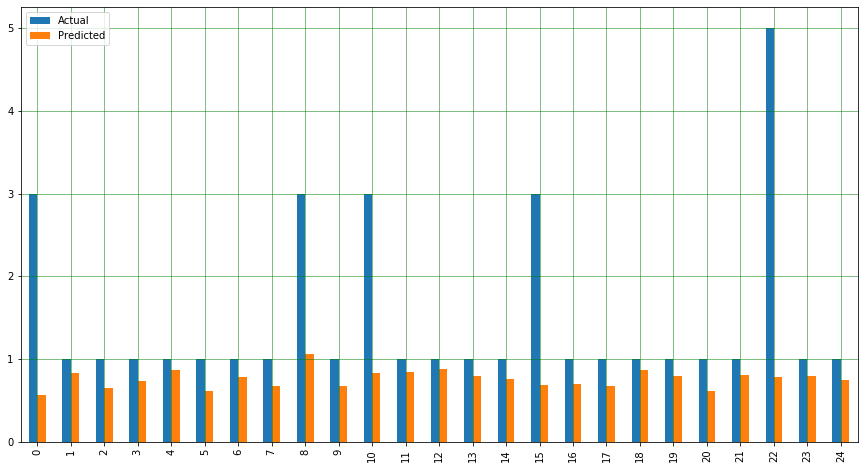

In [20]:
# Plot the comparison of Actual and Predicted value
out_df1 = out_df.head(25)
out_df1.plot(kind='bar',figsize=(15,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [21]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test_num, Y_predicted_num))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test_num, Y_predicted_num))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test_num, Y_predicted_num)))

Mean Absolute Error: 0.9726918243903974
Mean Squared Error: 3.547441935877256
Root Mean Squared Error: 1.883465406073936


In [22]:
# Label count.
groupby_actual = out_df.groupby("Actual", sort=True)["Predicted"].count()
groupby_actual.head()

Actual
1.0    1837
3.0     259
5.0      92
7.0     128
9.0       1
Name: Predicted, dtype: int64

In [23]:
# Per-label mean accuracy.
groupby_actual = out_df.groupby("Actual", sort=True)["Predicted"].mean()
groupby_actual.head()

Actual
1.0    0.751177
3.0    0.797791
5.0    0.822315
7.0    0.728243
9.0    0.809938
Name: Predicted, dtype: float64

In [24]:
for a, p in groupby_actual.items() :
    acc = (p/a)*100.0
    label = ContentRating_dict_2.get(a)
    print("Accuracy of " + "'" + str(label) + "' : " + "{:.2f}".format(acc) + "%")

Accuracy of 'Everyone' : 75.12%
Accuracy of 'Teen' : 26.59%
Accuracy of 'Everyone 10+' : 16.45%
Accuracy of 'Mature 17+' : 10.40%
Accuracy of 'Adults only 18+' : 9.00%
